In [ ]:
import os
import time
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# ✅ Disable Weights & Biases (W&B) logging
os.environ["WANDB_DISABLED"] = "true"

# 1️ Load PHEME Dataset
df = pd.read_csv("pheme-dataset-for-rumour-detection.csv")  # Update with correct dataset path
df = df.dropna(subset=["Body", "Label"])  # Drop NaNs

texts = df["Body"].astype(str).tolist()  # Convert text to string format
labels = df["Label"].astype(int).tolist()  # Ensure labels are integers (0 or 1)

# 2️ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)

# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization Function
def encode_texts(texts, tokenizer, max_len=100):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")

train_encodings = encode_texts(X_train, tokenizer)
test_encodings = encode_texts(X_test, tokenizer)

# 4️ Convert Data to Torch Dataset
class RumorDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

train_dataset = RumorDataset(train_encodings, y_train)
test_dataset = RumorDataset(test_encodings, y_test)

# 5️ Load Pre-trained BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 6️ Optimized Training Arguments
def get_training_args(output_dir, num_workers=8, fp16=True):
    return TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True,
        dataloader_num_workers=num_workers,  # Increase for parallelism
        gradient_accumulation_steps=2,  # Useful for memory efficiency
        fp16=fp16,  # Enable Mixed Precision Training
        report_to="none",
    )

# 7️ Define Metrics Function
def compute_metrics(pred):
    logits = pred.predictions
    preds = torch.argmax(torch.tensor(logits), axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(pred.label_ids, preds, average='binary')
    acc = accuracy_score(pred.label_ids, preds)
    cm = confusion_matrix(pred.label_ids, preds)

    print("\n🔹 Confusion Matrix:")
    print(cm)  # Prints confusion matrix
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# 8️ Optimized Parallel Training
print("\n🚀 Starting Optimized Parallel Training...")
start_time_opt = time.time()

training_args_opt = get_training_args("./results_opt", num_workers=8, fp16=True)
trainer_opt = Trainer(
    model=model,
    args=training_args_opt,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer_opt.train()
end_time_opt = time.time()

# Evaluate Optimized Model
opt_results = trainer_opt.evaluate()
opt_time = end_time_opt - start_time_opt
print(f"✅ Optimized Training Time: {opt_time:.2f} seconds")
print(f"✅ Optimized Accuracy: {opt_results['eval_accuracy']:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



🚀 Starting Optimized Parallel Training...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.239600,0.227203,0.916166,0.829371,0.782278,0.805137
2,0.073200,0.251636,0.924894,0.851211,0.800723,0.825196



🔹 Confusion Matrix:
[[9279  445]
 [ 602 2163]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🔹 Confusion Matrix:
[[9307  417]
 [ 534 2231]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🔹 Confusion Matrix:
[[9337  387]
 [ 551 2214]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🔹 Confusion Matrix:
[[9307  417]
 [ 534 2231]]
✅ Optimized Training Time: 958.08 seconds
✅ Optimized Accuracy: 0.9239


In [ ]:
# 📊 Print Comparison
print("\n📊 Final Comparison of Execution Times & Accuracy:")
print(f"⚡ Sequential Time (Baseline): {2821.93:.2f} sec | Accuracy: {0.9233:.4f}")
print(f"🚀 Optimized Time: {opt_time:.2f} sec | Accuracy: {opt_results['eval_accuracy']:.4f}")
speedup = 2821.93 / opt_time
print(f"⚡ Speedup Achieved: {speedup:.2f}x")

print(f"✅ Accuracy: {opt_results['eval_accuracy']:.4f}")
print(f"✅ Precision: {opt_results['eval_precision']:.4f}")
print(f"✅ Recall: {opt_results['eval_recall']:.4f}")
print(f"✅ F1-Score: {opt_results['eval_f1']:.4f}")


📊 Final Comparison of Execution Times & Accuracy:
⚡ Sequential Time (Baseline): 2821.93 sec | Accuracy: 0.9233
🚀 Optimized Time: 958.08 sec | Accuracy: 0.9239
⚡ Speedup Achieved: 2.95x
✅ Accuracy: 0.9239
✅ Precision: 0.8425
✅ Recall: 0.8069
✅ F1-Score: 0.8243


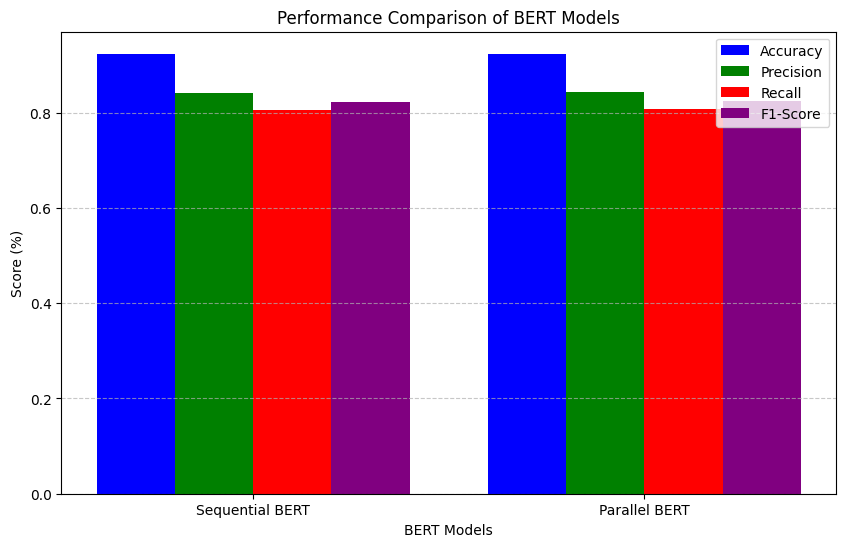

In [ ]:
import matplotlib.pyplot as plt
import numpy as np# Model names
models = ["Sequential BERT", "Parallel BERT"]

# Performance metrics
accuracy = [0.9233, 0.9239]
precision = [0.8416, 0.8425]
recall = [0.8051, 0.8069]
f1_score = [0.8229, 0.8243]

# X-axis positions
x = np.arange(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.3, accuracy, width=0.2, label="Accuracy", color="blue")
plt.bar(x - 0.1, precision, width=0.2, label="Precision", color="green")
plt.bar(x + 0.1, recall, width=0.2, label="Recall", color="red")
plt.bar(x + 0.3, f1_score, width=0.2, label="F1-Score", color="purple")

plt.xlabel("BERT Models")
plt.ylabel("Score (%)")
plt.title("Performance Comparison of BERT Models")
plt.xticks(ticks=x, labels=models)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


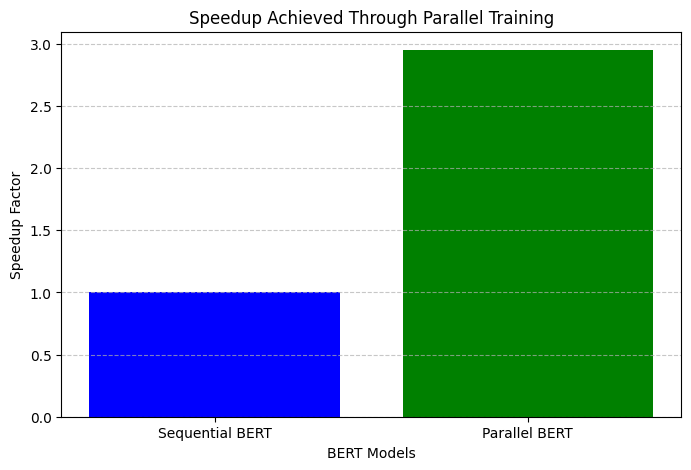

In [ ]:
import matplotlib.pyplot as plt
# Speedup factor
models = ["Sequential BERT", "Parallel BERT"]
training_times = [2821.93, 958.08]
speedup_factor = [1.0, 2.95]

plt.figure(figsize=(8, 5))
plt.bar(models, speedup_factor, color=["blue", "green"])
plt.xlabel("BERT Models")
plt.ylabel("Speedup Factor")
plt.title("Speedup Achieved Through Parallel Training")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


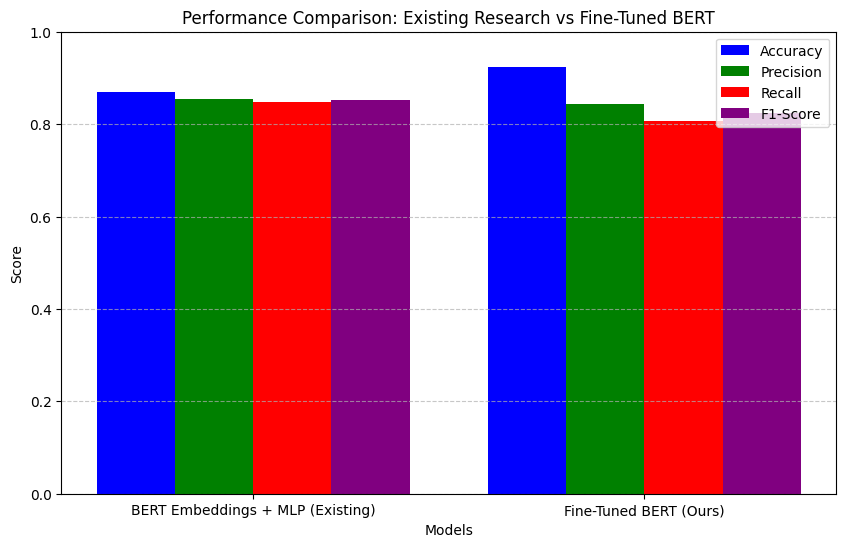

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data for comparison
models = ["BERT Embeddings + MLP (Existing)", "Fine-Tuned BERT (Ours)"]
accuracy = [0.869, 0.9239]
precision = [0.855, 0.8425]
recall = [0.848, 0.8069]
f1_score = [0.852, 0.8243]

# X-axis positions
x = np.arange(len(models))
width = 0.2

# Plot bars
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, accuracy, width, label="Accuracy", color="blue")
plt.bar(x - 0.5*width, precision, width, label="Precision", color="green")
plt.bar(x + 0.5*width, recall, width, label="Recall", color="red")
plt.bar(x + 1.5*width, f1_score, width, label="F1-Score", color="purple")

# Labels and limits
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Performance Comparison: Existing Research vs Fine-Tuned BERT")
plt.xticks(ticks=x, labels=models)
plt.ylim(0, 1)  # Ensuring the y-axis is between 0 and 1
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


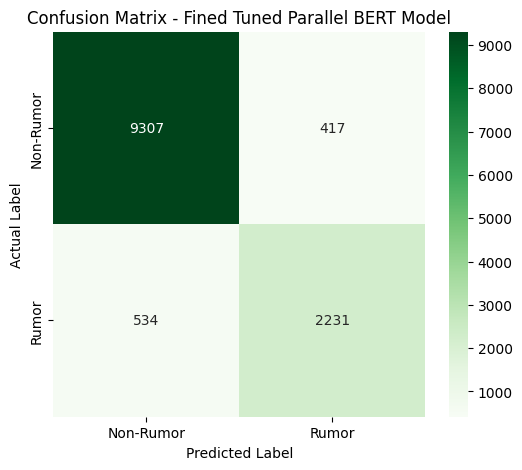

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Updated Confusion Matrix
cm_rf = np.array([[9307, 417],
                  [534, 2231]])

# Class labels
labels = ["Non-Rumor", "Rumor"]

# Plot confusion matrix with green color
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Fined Tuned Parallel BERT Model")

# Show plot
plt.show()


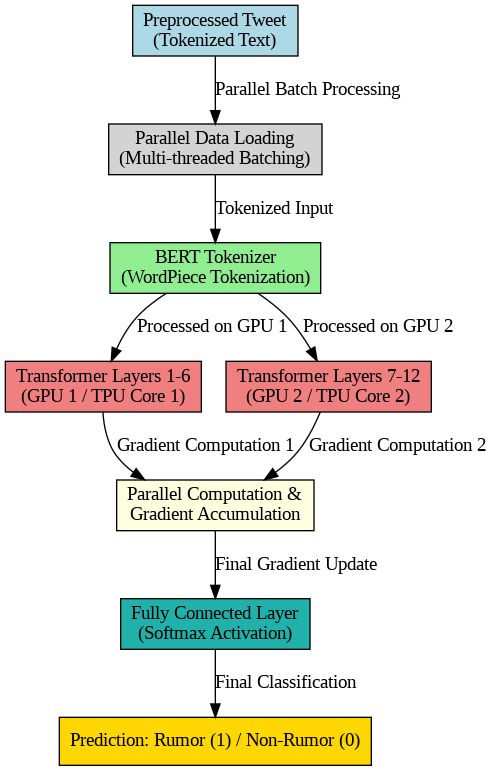

In [ ]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph(format="png")

# Input Layer (Preprocessed Text)
dot.node("Input", "Preprocessed Tweet\n(Tokenized Text)", shape="rectangle", style="filled", fillcolor="lightblue")

# Parallel Data Loading
dot.node("Parallel_Data", "Parallel Data Loading\n(Multi-threaded Batching)", shape="rectangle", style="filled", fillcolor="lightgray")

# Tokenizer Layer
dot.node("Tokenizer", "BERT Tokenizer\n(WordPiece Tokenization)", shape="rectangle", style="filled", fillcolor="lightgreen")

# Parallel Transformer Layers (Distributed across GPUs/TPUs)
dot.node("Transformer_GPU1", "Transformer Layers 1-6\n(GPU 1 / TPU Core 1)", shape="rectangle", style="filled", fillcolor="lightcoral")
dot.node("Transformer_GPU2", "Transformer Layers 7-12\n(GPU 2 / TPU Core 2)", shape="rectangle", style="filled", fillcolor="lightcoral")

# Parallel Computation Representation
dot.node("Parallel_Computation", "Parallel Computation &\nGradient Accumulation", shape="rectangle", style="filled", fillcolor="lightyellow")

# Fully Connected Layer
dot.node("FC", "Fully Connected Layer\n(Softmax Activation)", shape="rectangle", style="filled", fillcolor="lightseagreen")

# Output Layer
dot.node("Output", "Prediction: Rumor (1) / Non-Rumor (0)", shape="rectangle", style="filled", fillcolor="gold")

# Connect layers to represent data flow
dot.edge("Input", "Parallel_Data", label="Parallel Batch Processing")
dot.edge("Parallel_Data", "Tokenizer", label="Tokenized Input")
dot.edge("Tokenizer", "Transformer_GPU1", label="Processed on GPU 1")
dot.edge("Tokenizer", "Transformer_GPU2", label="Processed on GPU 2")

# Show that Transformer Layers are processed in parallel
dot.edge("Transformer_GPU1", "Parallel_Computation", label="Gradient Computation 1")
dot.edge("Transformer_GPU2", "Parallel_Computation", label="Gradient Computation 2")

# Connect the Gradient Aggregation step
dot.edge("Parallel_Computation", "FC", label="Final Gradient Update")

# Final Classification
dot.edge("FC", "Output", label="Final Classification")

# Save and render the diagram
dot.render("parallel_bert_architecture_diagram", format="png", cleanup=False)

# Display the diagram
from IPython.display import Image
Image("parallel_bert_architecture_diagram.png")
